In [13]:
from model import Wav2Vec2Model,Wav2Vec2Config,Wav2Vec2ForPreTraining,Wav2Vec2ForSequenceClassification
import random
from dataset import AudioDataset,AudioDatasetSplits
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from safetensors import safe_open
import os
from sklearn.metrics import f1_score,accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'


config = Wav2Vec2Config()#.from_pretrained('weights/config.json')

# Initialize the model architecture using the configuration
pre_trained_model = Wav2Vec2ForPreTraining(config)

# #Load the weights from the safetensors file
# state_dict = {}
# with safe_open('weights/model.safetensors', framework="pt", device=device) as f:
#     for key in f.keys():
#         state_dict[key] = f.get_tensor(key)

# Load the state dict into the model
#pre_trained_model.load_state_dict(state_dict)

datasets = AudioDatasetSplits()

In [14]:
datasets.train.label_2_id()

{'Crochet': 0,
 'Gould': 1,
 'Horowitz': 2,
 'Ishizaka': 3,
 'Moravec': 4,
 'Nikolayeva': 5,
 'Pogorelich': 6,
 'Richter': 7,
 'Rubinstein': 8,
 'Schiff': 9,
 'Tharaud': 10,
 'Tureck': 11}

In [26]:
model = Wav2Vec2ForSequenceClassification(pre_trained_model,datasets.num_classes)

model = model.to(device)

#state_dict = torch.load('finetune_weights/model_epoch_10.pt')
#model.load_state_dict(state_dict)

for i in range(10):
    ip,_,label = datasets.train[i].values()
    out = model(ip[0].unsqueeze(0).to(device)).argmax(dim=1)

    print(out.item(),label)

8 8
7 3
7 7
4 3
5 7
7 4
8 0
7 3
8 8
9 1


In [3]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=2)


train_dataloader = DataLoader(datasets.train, batch_size=8, shuffle=True)
val_dataloader = DataLoader(datasets.val, batch_size=8, shuffle=True)



In [20]:
epochs = 10

for epoch in range(epochs):
    torch.cuda.empty_cache()
    model.train()
    batch_iterator = tqdm(train_dataloader,desc=f'Processing Epoch: {epoch:02d}')
    running_loss = 0.0
    for batch_idx,batch in enumerate(batch_iterator):

        ip = batch['input_values'][0].to(device)

        labels = batch['label'].to(device)

        out = model(ip)



    

        loss = loss_fn(out,labels)


        optimizer.zero_grad()

        

        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()

        batch_iterator.set_postfix(loss=running_loss / (1 if batch_idx == 0 else batch_idx))
   # break
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        val_iterator = tqdm(val_dataloader,desc=f"Validating epoch: {epoch}")

        for idx,batch in enumerate(val_iterator):
            ip = batch['input_values'][0].to(device)

            labels = batch['label'].to(device)

            out = model(ip)

            loss = loss_fn(out,labels)

            val_loss += loss.item()

            probs = torch.softmax(out,dim=1)
            preds = torch.argmax(probs,dim=1)

            

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())



    val_acc = accuracy_score(all_labels,all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    torch.save(model.state_dict(), os.path.join('finetune_weights', f'model_epoch_{epoch+1}.pt'))

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss / len(val_dataloader)}, Validation F1 Score: {val_f1:.2f},Validation Acc: {val_acc:.2f}')




Processing Epoch: 00:   0%|          | 7/1550 [00:02<07:29,  3.43it/s, loss=3.82]


KeyboardInterrupt: 

In [4]:
test_dataloader = DataLoader(datasets.test, batch_size=8, shuffle=True)

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
test_loss = 0.0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    test_iterator = tqdm(test_dataloader, desc="Testing")

    for idx, batch in enumerate(test_iterator):
        ip = batch['input_values'][0].to(device)
        labels = batch['label'].to(device)

        out = model(ip)

        loss = loss_fn(out, labels)
        test_loss += loss.item()

        probs = torch.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())


Testing:   9%|▉         | 17/194 [00:01<00:19,  9.27it/s]


KeyboardInterrupt: 

In [6]:
out

tensor([[ 0.3252, -0.2386, -0.9572,  0.1405, -0.7305,  0.6155, -0.1085, -0.4771,
         -0.1236,  0.2581, -0.2244, -0.5296],
        [ 0.3224, -0.2342, -0.9100,  0.2146, -0.5378,  0.6604, -0.2443, -0.4097,
         -0.1282,  0.1878, -0.1735, -0.5262],
        [ 0.2846, -0.3275, -0.9491,  0.2391, -0.5662,  0.5844, -0.2383, -0.4311,
         -0.0516,  0.2479, -0.0875, -0.5297],
        [ 0.4207, -0.2295, -0.8924,  0.1104, -0.7145,  0.5740, -0.1996, -0.4068,
         -0.0647,  0.3830, -0.1468, -0.5363],
        [ 0.3460, -0.3734, -0.9776,  0.1973, -0.6381,  0.6440, -0.2045, -0.4535,
         -0.1016,  0.2216, -0.2028, -0.5101],
        [ 0.3062, -0.2741, -0.8756,  0.2055, -0.5688,  0.7017, -0.2342, -0.3259,
         -0.0975,  0.1338, -0.1345, -0.5153],
        [ 0.3567, -0.2160, -0.9101,  0.1789, -0.6061,  0.6829, -0.2987, -0.3059,
         -0.1022,  0.1239, -0.0868, -0.4644],
        [-0.3786,  0.1775, -0.4260,  0.3440, -0.3258,  0.5206, -0.0954, -0.1476,
         -0.1624, -0.7264,  0.

In [7]:
probs

tensor([[0.1245, 0.0708, 0.0345, 0.1035, 0.0433, 0.1664, 0.0807, 0.0558, 0.0795,
         0.1164, 0.0718, 0.0529],
        [0.1222, 0.0700, 0.0356, 0.1097, 0.0517, 0.1713, 0.0693, 0.0588, 0.0779,
         0.1068, 0.0744, 0.0523],
        [0.1182, 0.0641, 0.0344, 0.1130, 0.0505, 0.1596, 0.0701, 0.0578, 0.0845,
         0.1140, 0.0815, 0.0524],
        [0.1331, 0.0694, 0.0358, 0.0976, 0.0428, 0.1551, 0.0716, 0.0582, 0.0819,
         0.1281, 0.0754, 0.0511],
        [0.1268, 0.0618, 0.0337, 0.1093, 0.0474, 0.1708, 0.0731, 0.0570, 0.0810,
         0.1120, 0.0732, 0.0539],
        [0.1193, 0.0668, 0.0366, 0.1079, 0.0497, 0.1772, 0.0695, 0.0634, 0.0797,
         0.1004, 0.0768, 0.0525],
        [0.1251, 0.0706, 0.0353, 0.1048, 0.0478, 0.1734, 0.0650, 0.0645, 0.0791,
         0.0992, 0.0803, 0.0551],
        [0.0613, 0.1070, 0.0585, 0.1264, 0.0647, 0.1508, 0.0814, 0.0773, 0.0762,
         0.0433, 0.1054, 0.0478]], device='cuda:0')

Test Loss: 0.22979330402059653, Test F1 Score: 0.01, Test Acc: 0.07


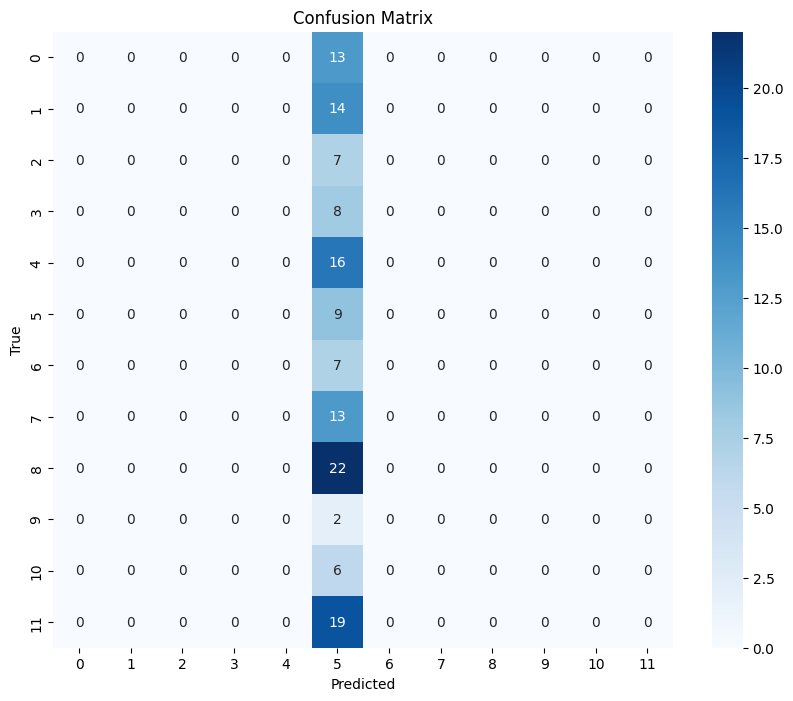

Classification Report:
               precision    recall  f1-score   support

     Crochet       0.00      0.00      0.00        13
       Gould       0.00      0.00      0.00        14
    Horowitz       0.00      0.00      0.00         7
    Ishizaka       0.00      0.00      0.00         8
     Moravec       0.00      0.00      0.00        16
  Nikolayeva       0.07      1.00      0.12         9
  Pogorelich       0.00      0.00      0.00         7
     Richter       0.00      0.00      0.00        13
  Rubinstein       0.00      0.00      0.00        22
      Schiff       0.00      0.00      0.00         2
     Tharaud       0.00      0.00      0.00         6
      Tureck       0.00      0.00      0.00        19

    accuracy                           0.07       136
   macro avg       0.01      0.08      0.01       136
weighted avg       0.00      0.07      0.01       136



/home/luke/projects/jupyterlab/Notebooks/song2vec/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luke/projects/jupyterlab/Notebooks/song2vec/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luke/projects/jupyterlab/Notebooks/song2vec/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [10]:
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'Test Loss: {test_loss / len(test_dataloader)}, Test F1 Score: {test_f1:.2f}, Test Acc: {test_acc:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_test_labels, all_test_preds, target_names=list(datasets.test.id_2_label().values()))
print("Classification Report:\n", class_report)
